## Evaluations of Vector RAG & Graph RAG

In [25]:
import os
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm
from typing import Union

from langchain.schema import Document
from langchain.prompts import PromptTemplate
from langchain_core.vectorstores import VectorStoreRetriever
from langchain.vectorstores import Chroma
from langchain_openai import ChatOpenAI
from langchain_huggingface import HuggingFaceEndpoint, ChatHuggingFace, HuggingFacePipeline
from langchain_neo4j import Neo4jVector, GraphCypherQAChain, Neo4jGraph
from langchain_openai import OpenAIEmbeddings
from langchain.text_splitter import RecursiveCharacterTextSplitter

from ragas.dataset_schema import EvaluationResult
from ragas import EvaluationDataset
from ragas import evaluate
from ragas.llms import LangchainLLMWrapper
from ragas.metrics import (
    SemanticSimilarity,
    AnswerRelevancy, 
    Faithfulness, 
    FactualCorrectness, 
    AnswerCorrectness, 
    LLMContextRecall, 
    ContextRecall, 
    ContextPrecision, 
)

metrics_list = [
    Faithfulness(),
    AnswerRelevancy(),
    SemanticSimilarity(),
    
]

np.random.seed(42)

### TO-DO
1. Track running time

In [26]:
# TODO: edit configuration
# Eval setting
SUBSET_SIZE = -1
EVAL_CACHE_DIR = "eval-semantic-human-qa-easy/"
# EVAL_CACHE_DIR = "eval-vector-auto-qa/"

USE_CACHE = True
GRAPH_RETRIEVAL_METHOD = "semantic"  # semantic or vector
EVAL_SET = [
    # "VectorRAG_Baseline", 
    # "Microsoft_GraphRAG (generic fewshots)",
    # "Microsoft_GraphRAG (finetuned fewshots)",
    "LLMGraphTransformer_GraphRAG_1",
    "LLMGraphTransformer_GraphRAG_1_1",
    # "LLMGraphTransformer_GraphRAG_2",
    # "LlamaIndex_GraphRAG",
    # "OpenAI_GraphRAG",
]

RETRIEVER_CONFIG = {
    k: None for k in EVAL_SET
}

# General RAG setting
TOP_K = 3

# Vector RAG setting
CHUNK_SIZE = 512
CHUNK_OVERLAP = 32

In [27]:
# load environment variables
from dotenv import load_dotenv
load_dotenv("./private-config.env")

True

In [28]:
def empty_cache():
    os.remove(EVAL_CACHE_DIR, ignore_errors=True)
    os.remove(os.environ["CHROMA_DB"], ignore_errors=True)
    os.remove(os.environ["QR_DATA"], ignore_errors=True)

if not USE_CACHE:
    empty_cache()

### LLM Config

In [29]:
# Embedding model
embed = OpenAIEmbeddings()

# LLM model
llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    max_tokens=None,
    timeout=None,
    max_retries=2,
)

In [ ]:
# coding_llm = HuggingFacePipeline.from_model_id(
#     model_id="Qwen/Qwen2.5-Coder-1.5B-Instruct",
#     task="text-generation",
#     model_kwargs={"use_cache": True},
#     pipeline_kwargs={"max_length": 512, "truncation": True},
# )

tokenizer_config.json:   0%|          | 0.00/7.30k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/2.78M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/1.67M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/7.03M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/661 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/35.6k [00:00<?, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/1.21G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
# neo4j = neo4j_config["LLMGraphTransformer_GraphRAG_1"]
# uri = neo4j["uri"]
# username = neo4j["username"]
# password = neo4j["password"]
# graph = Neo4jGraph(
#     url=uri,
#     username=username,
#     password=password,
#     database="neo4j",
# )
# chain = GraphCypherQAChain.from_llm(
#     cypher_llm=coding_llm,
#     qa_llm=llm,
#     graph=graph,
#     verbose=True,
#     allow_dangerous_requests=True,
# )

In [ ]:
# chain.invoke("How many products does SK-II offer in the collection?")

### QR Dataset Preparation

In [ ]:
def prepare_product_df() -> pd.DataFrame:
    """
    Load the Amazon product dataset and filter for beauty products.
    """
    df = pd.read_csv("./data/cosmetics_25_products.csv", index_col=0)
    df.columns = df.columns.str.lower()
    df["title"] = df["name"]
    return df


# def prepare_product_df():
#     # Read data from a text file
#     with open('data/message.txt', 'r', encoding='utf-8') as file:
#         data = file.read()

#     # Split into products by splitting on double newlines
#     products = data.strip().split('\n\n')

#     # Prepare list to hold each product's data
#     product_list = []

#     for product in products:
#         product_data = {}

#         # Extract each line that contains ':'
#         lines = product.split('\n')
#         for line in lines:
#             if ':' in line:
#                 key, value = line.split(':', 1)  # Split only at the first colon
#                 product_data[key.strip().lower()] = value.strip()

#         product_list.append(product_data)

#     # Convert list to DataFrame
#     return pd.DataFrame(product_list)

In [ ]:
async def generate_qr_data(
        df: pd.DataFrame, 
        llm: ChatOpenAI,
        metadata_fields: list = ["description", "title"],
        num_questions_per_chunk: int = 1,
    ) -> pd.DataFrame:
    """
    Generate QR data for the given DataFrame.
    """
    from llama_index.core import Document
    from llama_index.core.evaluation import DatasetGenerator
    cols = df.columns

    docs = []
    for i, row in df.iterrows():
        doctext = [f"{col}: {row[col]}" for col in cols]
        doctext = "\n".join(doctext)
        doc = Document(
            text=doctext,
            metadata={field: row[field] for field in metadata_fields},
        )
        docs.append(doc)

    dataset_generator = DatasetGenerator.from_documents(
        docs,
        num_questions_per_chunk=num_questions_per_chunk,
        show_progress=True,
    )
    qr_ds = await dataset_generator.agenerate_dataset_from_nodes()
    qr_ds.save_json(os.environ["QR_DATA"])
    qr_ds = {
        "queries": qr_ds.queries,
        "responses": qr_ds.responses,
    }
    return qr_ds

In [ ]:
# Load QA data
df = prepare_product_df()
if not os.path.exists(os.environ["QR_DATA"]):
    df = prepare_product_df()
    print(f"Loaded {len(df)} products")
    qr_data = await generate_qr_data(
        df,
        llm,
        metadata_fields=["description", "title"],
        num_questions_per_chunk=1,
    )
else:
    with open(os.environ["QR_DATA"], "r") as f:
        qr_data = json.load(f)

In [ ]:
# load question-response dataset in json format for evaluation
questions = [q for q in qr_data['queries'].values()]
responses = [r for r in qr_data['responses'].values()]
size = len(questions)
idx = np.random.randint(0, size, SUBSET_SIZE) if SUBSET_SIZE > 0 else np.arange(size)
questions, responses = [questions[i] for i in idx], [responses[i] for i in idx]
len(questions), len(responses)

(10, 10)

### Vector RAG

In [ ]:
def df2docs(df: pd.DataFrame) -> list[Document]:
    """
    Convert DataFrame to list of Documents.
    """
    docs = []
    for i, row in df.iterrows():
        doctext = [f"{col}: {row[col]}" for col in df.columns]
        doctext = "\n".join(doctext)
        doc = Document(
            page_content=doctext,
            metadata={col: row[col] for col in df.columns},
        )
        docs.append(doc)
    return docs


documents = df2docs(df)
# Split documents into chunks
text_splitter = RecursiveCharacterTextSplitter(chunk_size=CHUNK_SIZE, chunk_overlap=CHUNK_OVERLAP)
docstore = text_splitter.split_documents(documents)

# Create ChromaDB and store embeddings
db = Chroma.from_documents(docstore, embed, persist_directory="./chroma_db")

# Create a retriever
vecstore = db.as_retriever(search_kwargs={"k": TOP_K})

### GraphRAG - Vector Search

In [ ]:
def get_graphstore(
        url: str, 
        username: str,
        password: str,
    ) -> Neo4jVector:
    """
    Create a Neo4j vector store.
    """
    graph_vecstore = Neo4jVector.from_existing_graph(
        embedding=embed,
        url=url,
        username=username,
        password=password,
        index_name="product_index",
        node_label="Product",
        text_node_properties=["description"],
        embedding_node_property="embedding",
    )
    return graph_vecstore

### GraphRAG - Semantic Search (Cypher)

In [ ]:
CYPHER_QA_TEMPLATE = """Task:Generate Cypher statement to query a graph database based on few-shot samples.
Instructions:
Use only the provided relationship types and properties in the schema.
Do not use any other relationship types or properties that are not provided.

Schema:
{schema}

Here are some examples of question and Cypher statement pairs, review them and use them as a reference to generate your own Cypher statement.
Few shot examples: 
1. What is the price range of all the products in the dataset?
Cyhpher Query:
MATCH (p:Product)-[h:HAS_PRICE]->(pr:Price)
WITH p, pr, toInteger(pr.id) AS priceId
RETURN min(priceId) AS minPrice, max(priceId) AS maxPrice

2. How many products have a rating above 4?
Cyhpher Query:
MATCH (p:Product)-[r:HAS_RATING]->(ra:Rating)
WITH p, toFloat(ra.id) AS rating
WHERE rating > 4.0
RETURN count(p)

3. What Estee Lauder products are not suitable for sensitive skin?
Cypher Query:
MATCH (b:Brand {id: "Estee Lauder"})-[:FROM_BRAND]->(p:Product)
WHERE NOT EXISTS {  
MATCH (p)-[:FOR_SKIN_TYPE]->(st:Skin_type {id: "sensitive"}) }
RETURN p

The question is:
{question}

Note: Do not include any explanations or apologies in your responses.
Do not respond to any questions that might ask anything else than for you to construct a Cypher statement.
Do not include any text except the generated Cypher statement.
"""

def get_cypher_chain(
    llm: ChatOpenAI,
    url: str,
    username: str,
    password: str,
) -> GraphCypherQAChain:
    return GraphCypherQAChain.from_llm(
        graph=Neo4jGraph(
            url=url,
            username=username,
            password=password,
        ),
        # # few shot usage
        # cypher_prompt=PromptTemplate(
        #     template=CYPHER_QA_TEMPLATE,
        #     input_variables=["schema", "question"],
        # ),
        cypher_llm=llm,
        qa_llm=llm,
        verbose=True,
        enhanced_schema=True,
        allow_dangerous_requests=True,
        return_intermediate_steps=True,
    )

In [ ]:
def cypher_retrieve(cypher_chain: GraphCypherQAChain, query: str) -> list[Document]:
    
    response = cypher_chain.invoke({"query": query})

    # cypher_query = Document(f"""
    # Cypher Query:
    # {response["intermediate_steps"][0]["query"]}
    # """)
    # schema = Document(f"""
    # Schema:
    # {cypher_chain.graph.schema}
    # """)
    relevant_docs = response["intermediate_steps"][1]["context"]
    relevant_docs = [Document(str(doc)) for doc in relevant_docs]
    answer = response["result"]
    return relevant_docs, answer

In [ ]:
neo4j_config = json.load(open(os.environ["NEO4J_CONFIG"], 'r'))
for method in EVAL_SET:
    if method == "VectorRAG_Baseline":
        RETRIEVER_CONFIG[method] = vecstore
    elif "GraphRAG" in method:
        if os.path.exists(os.path.join(EVAL_CACHE_DIR, f"{method}.csv")):
            print(f"Skipping config for {method} as it is already evaluated")
            continue
        url = neo4j_config[method]["uri"]
        username = neo4j_config[method]["username"]
        password = neo4j_config[method]["password"]
        if GRAPH_RETRIEVAL_METHOD == "vector":
            graphstore = get_graphstore(url, username, password)
        elif GRAPH_RETRIEVAL_METHOD == "semantic":
            graphstore = get_cypher_chain(llm, url, username, password)
        else: 
            raise ValueError(f"Unknown graph retrieval method: {GRAPH_RETRIEVAL_METHOD}")
        RETRIEVER_CONFIG[method] = graphstore
    else:
        raise ValueError(f"Unknown method: {method}")

Skipping config for LLMGraphTransformer_GraphRAG_1_1 as it is already evaluated


### Evaluation on Question Answering Task

In [ ]:
def eval_qr_data(
        questions: list[str], 
        responses: list[str], 
        retriever: Union[VectorStoreRetriever, Neo4jVector, GraphCypherQAChain], 
        llm: ChatOpenAI,
    ) -> EvaluationDataset:
    """
    Wraps the evaluation data into a list of dictionaries.
    """
    dataset = []
    response = None

    for query, reference in tqdm(zip(questions, responses), total=len(questions)):

        if isinstance(retriever, VectorStoreRetriever):
            relevant_docs = retriever.invoke(query)
        elif isinstance(retriever, Neo4jVector):
            relevant_docs = retriever.similarity_search(query, k=TOP_K)
        elif isinstance(retriever, GraphCypherQAChain):
            try:
                relevant_docs, response = cypher_retrieve(retriever, query)
            # sometimes the cypher query fails, so we skip it
            except Exception as e:
                print(f"Cypher QA Chain failed, skipping query: {query}")
                continue
        else:
            raise ValueError("Unsupported retriever type")
        
        relevant_context = "\n".join([doc.page_content for doc in relevant_docs])
        prompt = f"""
        Based on the following context, answer the question:\n
        {relevant_context}\n
        Question: {query}\n
        Answer:
        """
        response = llm.invoke(prompt).content if response is None else response
        dataset.append(
            {
                "user_input":query,
                "retrieved_contexts":[d.page_content for d in relevant_docs],
                "response":response,
                "reference":reference
            }
        )

    return EvaluationDataset.from_list(dataset)

def eval(method: str, eval_llm: ChatOpenAI) -> EvaluationResult:
    retriever = RETRIEVER_CONFIG[method]
    print(f"Evaluating {method} ...")
    # Prepare the evaluation data
    eval_data = eval_qr_data(
        questions=questions,
        responses=responses,
        retriever=retriever,
        llm=llm,
    )
    # Eval
    eval_result = evaluate(
        dataset=eval_data,
        metrics=metrics_list,
        llm=eval_llm,
    )
    # Save the evaluation result
    eval_result.to_pandas().to_csv(
        os.path.join(EVAL_CACHE_DIR, f"{method}.csv"),
    )
    return eval_result

In [ ]:
def parse_eval_results(
        eval_result: Union[EvaluationResult, pd.DataFrame], 
        method_name: str,
    ) -> pd.DataFrame:
    """
    Parses the evaluation results into a DataFrame.
    """
    if isinstance(eval_result, EvaluationResult):
        # Convert the evaluation result to a DataFrame
        eval_df = eval_result.to_pandas()
        metrics_names = [i for i in eval_result.scores[0].keys()]
    else:
        # If it's already a DataFrame, use it directly
        eval_df = eval_result
        metrics_names = [col for col in eval_result.columns if col not in ["user_input", "retrieved_contexts", "response", "reference"]]
    eval_df_long = pd.melt(
        eval_df,
        value_vars=metrics_names,  # Columns to unpivot
        var_name='metric',             # Name for the variable column
        value_name='score'              # Name for the value column
    )
    eval_df_long['method'] = method_name
    return eval_df_long

In [ ]:
evaluator_llm = LangchainLLMWrapper(llm)

In [ ]:
eval_df = pd.DataFrame()
if not os.path.exists(EVAL_CACHE_DIR):
    os.makedirs(EVAL_CACHE_DIR)
for method in EVAL_SET:
    if os.path.exists(os.path.join(EVAL_CACHE_DIR, f"{method}.csv")):
        print(f"Loading result of {method} ...")
        eval_result = pd.read_csv(os.path.join(EVAL_CACHE_DIR, f"{method}.csv"), index_col=0)
    else:
        eval_result = eval(method, evaluator_llm)
    df = parse_eval_results(eval_result, method)
    eval_df = pd.concat([eval_df, df], ignore_index=True)
eval_df.shape

Evaluating LLMGraphTransformer_GraphRAG_1 ...


  0%|          | 0/10 [00:00<?, ?it/s]



> Entering new GraphCypherQAChain chain...


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownPropertyKeyWarning} {category: UNRECOGNIZED} {title: The provided property key is not in the database} {description: One of the property names in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing property name is: product_type)} {position: line: 2, column: 27, offset: 33} for query: "cypher\nMATCH (p:Product) WHERE p.product_type = 'Moisturizer'\nRETURN count(p) AS num_products\n"


Generated Cypher:
cypher
MATCH (p:Product) WHERE p.product_type = 'Moisturizer'
RETURN count(p) AS num_products

Full Context:
[{'num_products': 0}]


 10%|█         | 1/10 [00:16<02:26, 16.28s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
cypher
MATCH (b:Brand {name: 'SK-II'})-[:FROM_BRAND]->(p:Product)
RETURN count(p) AS product_count



Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownPropertyKeyWarning} {category: UNRECOGNIZED} {title: The provided property key is not in the database} {description: One of the property names in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing property name is: name)} {position: line: 2, column: 17, offset: 23} for query: "cypher\nMATCH (b:Brand {name: 'SK-II'})-[:FROM_BRAND]->(p:Product)\nRETURN count(p) AS product_count\n"


Full Context:
[{'product_count': 0}]


 20%|██        | 2/10 [00:29<01:56, 14.53s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownPropertyKeyWarning} {category: UNRECOGNIZED} {title: The provided property key is not in the database} {description: One of the property names in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing property name is: name)} {position: line: 2, column: 17, offset: 23} for query: "cypher\nMATCH (b:Brand {name: 'LA MER'})-[:FROM_BRAND]->(p:Product)\nWITH p\nRETURN AVG(p.price) AS avg_price\n"
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownPropertyKeyWarning} {category: UNRECOGNIZED} {title: The provided property key is not in the database} {description: One of the property names in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this sta

Generated Cypher:
cypher
MATCH (b:Brand {name: 'LA MER'})-[:FROM_BRAND]->(p:Product)
WITH p
RETURN AVG(p.price) AS avg_price

Full Context:
[{'avg_price': None}]


 30%|███       | 3/10 [00:42<01:36, 13.82s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownPropertyKeyWarning} {category: UNRECOGNIZED} {title: The provided property key is not in the database} {description: One of the property names in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing property name is: name)} {position: line: 2, column: 53, offset: 53} for query: "\nMATCH (p:Product)-[r:FOR_SKIN_TYPE]->(st:Skin_type {name: 'Sensitive'})\nRETURN count(p) AS num_products\n"


Generated Cypher:

MATCH (p:Product)-[r:FOR_SKIN_TYPE]->(st:Skin_type {name: 'Sensitive'})
RETURN count(p) AS num_products

Full Context:
[{'num_products': 0}]


 40%|████      | 4/10 [00:48<01:04, 10.68s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownPropertyKeyWarning} {category: UNRECOGNIZED} {title: The provided property key is not in the database} {description: One of the property names in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing property name is: price)} {position: line: 3, column: 10, offset: 54} for query: "\nMATCH (p:Product)-[r:HAS_PRICE]->(pr:Price)\nWHERE pr.price < 50 AND p.product_type = 'Eye Cream'\nRETURN count(p) AS num_products\n"
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownPropertyKeyWarning} {category: UNRECOGNIZED} {title: The provided property key is not in the database} {description: One of the property names in your query is not available in the database, make sure you didn't misspell it or that the label is availab

Generated Cypher:

MATCH (p:Product)-[r:HAS_PRICE]->(pr:Price)
WHERE pr.price < 50 AND p.product_type = 'Eye Cream'
RETURN count(p) AS num_products

Full Context:
[{'num_products': 0}]


 50%|█████     | 5/10 [01:01<00:57, 11.41s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...


 60%|██████    | 6/10 [01:13<00:46, 11.70s/it]

Generated Cypher:
Task:`Generate Cypher statement to query a graph database`.
Instructions:`Use only the provided relationship types and properties in the schema`.
Do not use any other relationship types or properties that are not provided.
Schema:`Node properties`:
Document {id: STRING}
Chunk {id: STRING, text: STRING, textEmbedding: LIST}
Brand {id: STRING}
Product_type {id: STRING}
Product {id: STRING}
Price {id: STRING}
Rating {id: STRING}
Ingredients {id: STRING}
Skin_type {id: STRING}
Size {id: STRING}
Description {id: STRING}
Relationship properties:`The relationships`:
(:Chunk)-[:PART_OF]->(:Document)
(:Chunk)-[:HAS_PRODUCT]->(:Product)
(:Brand)-[:FROM_BRAND]->(:Product)
(:Product_type)-[:HAS_PRODUCT_TYPE]->(:Product)
(:Product)-[:FROM_BRAND]->(:Brand)
(:Product)-[:HAS_PRODUCT_TYPE]->(:Product_type)
(:Product)-[:HAS_PRICE]->(:Price)
(:Product)-[:HAS_RATING]->(:Rating)
(:Product)-[:CONTAINS_INGREDIENT]->(:Ingredients)
(:Product)-[:FOR_SKIN_TYPE]->(:Skin_type)
(:Product)-[:IN_SIZ

Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownPropertyKeyWarning} {category: UNRECOGNIZED} {title: The provided property key is not in the database} {description: One of the property names in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing property name is: for_skin_type)} {position: line: 2, column: 20, offset: 26} for query: "cypher\nMATCH (p1:Product {for_skin_type: 'Moisturizer'})-[r:HAS_PRICE]->(p2:Product {for_skin_type: 'Moisturizer'})\nRETURN p2.price - p1.price AS price_difference\nORDER BY price_difference DESC LIMIT 1\n"
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownPropertyKeyWarning} {category: UNRECOGNIZED} {title: The provided property key is not in the database} {description: One of the property names in your query is not availabl

Generated Cypher:
cypher
MATCH (p1:Product {for_skin_type: 'Moisturizer'})-[r:HAS_PRICE]->(p2:Product {for_skin_type: 'Moisturizer'})
RETURN p2.price - p1.price AS price_difference
ORDER BY price_difference DESC LIMIT 1

Full Context:
[]


 70%|███████   | 7/10 [01:19<00:29,  9.74s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...
Generated Cypher:
Task:`Generate Cypher statement to query a graph database`.
Instructions:`Use only the provided relationship types and properties in the schema`.
Do not use any other relationship types or properties that are not provided.
Schema:`Node properties`:
Document {id: STRING}
Chunk {id: STRING, text: STRING, textEmbedding: LIST}
Brand {id: STRING}
Product_type {id: STRING}
Product {id: STRING}
Price {id: STRING}
Rating {id: STRING}
Ingredients {id: STRING}
Skin_type {id: STRING}
Size {id: STRING}
Description {id: STRING}
Relationship properties:`The relationships`:
(:Chunk)-[:PART_OF]->(:Document)
(:Chunk)-[:HAS_PRODUCT]->(:Product)
(:Brand)-[:FROM_BRAND]->(:Product)
(:Product_type)-[:HAS_PRODUCT_TYPE]->(:Product)
(:Product)-[:FROM_BRAND]->(:Brand)
(:Product)-[:HAS_PRODUCT_TYPE]->(:Product_type)
(:Product)-[:HAS_PRICE]->(:Price)
(:Product)-[:HAS_RATING]->(:Rating)
(:Product)-[:CONTAINS_INGREDIENT]->(:Ingredient

 80%|████████  | 8/10 [01:31<00:21, 10.56s/it]

Cypher QA Chain failed, skipping query: Which skin type has the most product options available, and how many more products does it have compared to the least represented skin type?


> Entering new GraphCypherQAChain chain...


Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownPropertyKeyWarning} {category: UNRECOGNIZED} {title: The provided property key is not in the database} {description: One of the property names in your query is not available in the database, make sure you didn't misspell it or that the label is available when you run this statement in your application (the missing property name is: name)} {position: line: 2, column: 52, offset: 58} for query: "cypher\nMATCH (b1:Brand)-[:FOR_SKIN_TYPE]->(st1:Skin_type {name: 'Dry'})-[:HAS_PRODUCT]->(p1:Product)\nWHERE b1.name IN ['SK-II', 'ESTEE LAUDER']\nRETURN b1.name AS BrandName, count(*) AS NumberOfProducts, min(p1.price) AS MinPrice, max(p1.price) AS MaxPrice\nORDER BY NumberOfProducts DESC;\n"
Received notification from DBMS server: {severity: WARNING} {code: Neo.ClientNotification.Statement.UnknownPropertyKeyWarning} {category: UNRECOGNIZED} {title: The provided property key is not in the d

Generated Cypher:
cypher
MATCH (b1:Brand)-[:FOR_SKIN_TYPE]->(st1:Skin_type {name: 'Dry'})-[:HAS_PRODUCT]->(p1:Product)
WHERE b1.name IN ['SK-II', 'ESTEE LAUDER']
RETURN b1.name AS BrandName, count(*) AS NumberOfProducts, min(p1.price) AS MinPrice, max(p1.price) AS MaxPrice
ORDER BY NumberOfProducts DESC;

Full Context:
[]


 90%|█████████ | 9/10 [01:44<00:11, 11.28s/it]


> Finished chain.


> Entering new GraphCypherQAChain chain...


100%|██████████| 10/10 [01:56<00:00, 11.67s/it]

Generated Cypher:
Task:`Generate Cypher statement to query a graph database`.
Instructions:`Use only the provided relationship types and properties in the schema`.
Do not use any other relationship types or properties that are not provided.
Schema:`Node properties`:
Document {id: STRING}
Chunk {id: STRING, text: STRING, textEmbedding: LIST}
Brand {id: STRING}
Product_type {id: STRING}
Product {id: STRING}
Price {id: STRING}
Rating {id: STRING}
Ingredients {id: STRING}
Skin_type {id: STRING}
Size {id: STRING}
Description {id: STRING}
Relationship properties:`The relationships`:
(:Chunk)-[:PART_OF]->(:Document)
(:Chunk)-[:HAS_PRODUCT]->(:Product)
(:Brand)-[:FROM_BRAND]->(:Product)
(:Product_type)-[:HAS_PRODUCT_TYPE]->(:Product)
(:Product)-[:FROM_BRAND]->(:Brand)
(:Product)-[:HAS_PRODUCT_TYPE]->(:Product_type)
(:Product)-[:HAS_PRICE]->(:Price)
(:Product)-[:HAS_RATING]->(:Rating)
(:Product)-[:CONTAINS_INGREDIENT]->(:Ingredients)
(:Product)-[:FOR_SKIN_TYPE]->(:Skin_type)
(:Product)-[:IN_SIZ

Evaluating:   0%|          | 0/21 [00:00<?, ?it/s]

Loading result of LLMGraphTransformer_GraphRAG_1_1 ...


(45, 3)

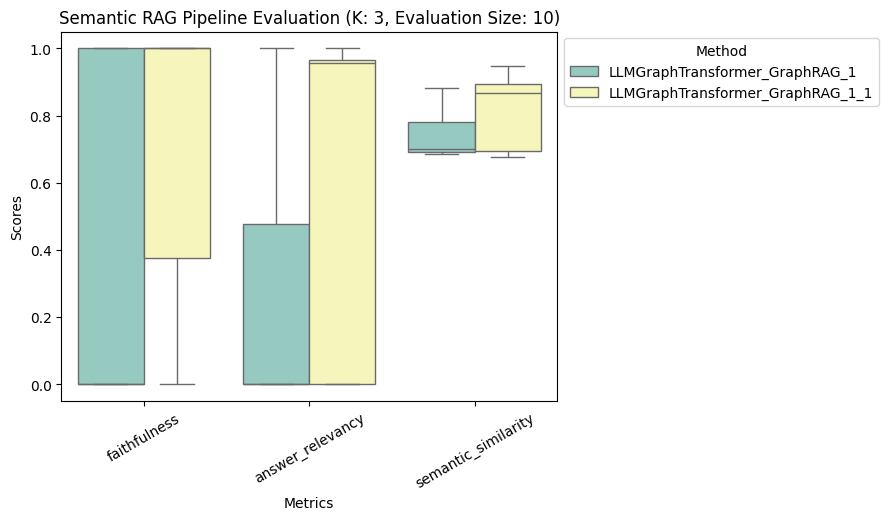

In [ ]:
# boxplot for all metrics
sns.boxplot(
    x="metric",
    y="score",
    hue="method",
    hue_order=EVAL_SET,
    data=eval_df,
    palette="Set3",
    showfliers=False,
)
plt.xticks(rotation=30)
plt.title(f"Semantic RAG Pipeline Evaluation (K: {TOP_K}, Evaluation Size: {SUBSET_SIZE if SUBSET_SIZE > 0 else size})")
plt.legend(title="Method", loc="upper left", bbox_to_anchor=(1, 1))
plt.xlabel("Metrics")
plt.ylabel("Scores")
plt.show()

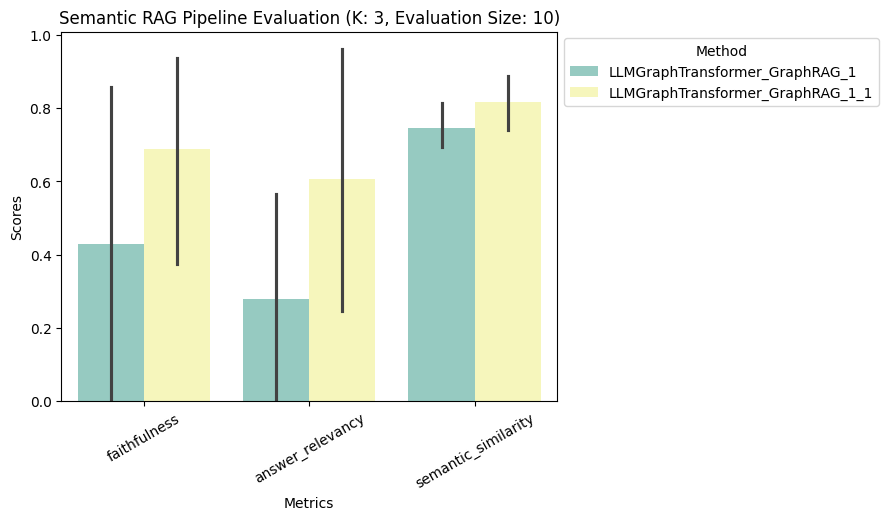

In [ ]:
# bar plot for all metrics
sns.barplot(
    x="metric",
    y="score",
    hue="method",
    hue_order=EVAL_SET,
    data=eval_df,
    palette="Set3",
)
plt.xticks(rotation=30)
plt.title(f"Semantic RAG Pipeline Evaluation (K: {TOP_K}, Evaluation Size: {SUBSET_SIZE if SUBSET_SIZE > 0 else size})")
plt.legend(title="Method", loc="upper left", bbox_to_anchor=(1, 1))
plt.xlabel("Metrics")
plt.ylabel("Scores")
plt.show()
# Save the evaluation result